In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import astropy.units as u
import pandas as pd

# RELOJ SOLAR

### Uso del programa
A continuación se explica la forma del código creado con el fin de obtener un Reloj Solar, o *Sundial*. Los datos adjuntos importantes son las siguientes listas:
+ **Altacim:** Es un arreglo en 3D (Nhoras,Ndias,2) que para cada hora lista las coordenadas altacimutales del Analema Solar para Miami.
+ **PointsXY** ó **PointsTR:** Son arreglos en 3D (Nhoras,Ndias,2) que contienen la proyección de dicho Analema como una sombra sobre el plano xy. A saber, la escala utilizada toma $1$ como la altura del gnomon, o en este caso, el SaturnoV que proyectará la sombra. Escalar según la necesidad. La lista XY es la que tiene los puntos cartesianos, y la lista TR es la que los tiene en coordenadas polares (Theta,R).
+ **PointsXY2** ó **PointsTR2:** Aunque parezca trivial es un reshape de las listas anteriores pero en la forma (Ndias,Nhoras,2), de forma que si se grafica cada una de las listas del primer eje, no da como resultado el analema (Misma hora graficada en días diferentes) sino la trayectoria natural de la sombra (Mismo día graficado en horas diferentes).
+ **HoraMinMaxXY** u **HoraMinMaxTR:** En muchos casos, los relojes solares no tienen en cuenta la ecuación del tiempo, entonces este arreglo contiene el máximo y mínimo de los Analemas para trazar la línea recta promedio. Son arreglod 3D (Nhoras,2,2) pues hay para cada hora dos puntos coordenados.

Una complicación de la transferencia de los datos es el hecho de que estén en tres dimensiones, por este motivo se crearon las funciones `save3d` y `load3d` que toman como argumento el nombre del archivo en forma de string, sin extensión de archivo ni carpeta; TODOS los archivos deben estar en una carpeta adjunta llamada RelojSolar para que funcionen estos comandos, o si no, hay que cambiarlos en el bloque de código de aquí abajo. Muy básicamente, lo que hacen es tomar los puntos coordenados y volverlos un solo elemento tipo texto para tener así un arreglo de string en 2D y poderlo almacenar en un archivo excel (.xlsx).

En resumidas cuentas, para graficar elementos del Reloj Solar:
+ **Analema de cada Hora:** Usar los arreglos **Points**
+ **Línea promedio de cada Hora:** Usar los arreglos **HoraMinMax**
+ **Lineas Horizontales de Meses:** Usar los arreglos **Points2**

Además, me parece más recomendable hacerlo todo en coordenadas polares pero es a discreción suya.

In [2]:
#Exportando
def save3d(name,L): #En name solo poner el nombre en str, el programa le asigna la ruta y la extensión
    a,b,c = L.shape
    OUT = []
    for i in range(a):
        OUT.append([])
        for j in range(b):
            x = str(L[i,j,0])
            y = str(L[i,j,1])
            xy = x+","+y
            OUT[i].append(xy)
    OUT2 = pd.DataFrame(OUT)
    OUT2.to_excel("RelojSolar/"+name+".xlsx")

def load3d(name): #Usar para definir una lista: Lista1 = load3d("nombre_de_archivo_sin_extensión")
    IN = pd.read_excel("RelojSolar/"+name+".xlsx",index_col=0)
    a,b = IN.shape
    OUT = np.full((a,b,2),np.nan)
    for i in range(a):
        for j in range(b):
            x,y = IN.iloc[i,j].split(',')
            OUT[i,j] = [x,y]
    return OUT

In [3]:
Lat_Miami = 35.7 #Latitud de Miami
Lon_Miami = -100.6 #Longitud de Miami
dT = Lon_Miami / 15 #Diferencia Horaria en Miami
Miami = EarthLocation(Lon_Miami,Lat_Miami)

In [4]:
k = 7
Hs = np.array(range(23))[k:25-k] #Horas donde el Sol está Afuera (Entre k y 25-k)
Nhoras = len(Hs)
Ndias = 90 #Cantidad de Días del Año a Plottear
Dias = np.linspace(0,365,Ndias)

Altacim  = np.zeros((Nhoras,Ndias,2)) #Coordenadas Altacimutales del Sol
PointsXY = np.zeros((Nhoras,Ndias,2)) #Puntos Coordenados en XY para la Sombra
PointsTR = np.zeros((Nhoras,Ndias,2)) #Puntos Coordenados en Polares para la Sombra (TR por Theta y Radio)

HoraMinMaxXY = np.zeros((Nhoras,2,2)) #Puntos Máximo y Mínimo para cada hora en Cartesianas
HoraMinMaxTR = np.zeros((Nhoras,2,2)) #Puntos Máximo y Mínimo para cada hora en Polares

def Sombra(L): #Input es la Lista de Coordenadas Acimut-Altura
    if L[1] <= 5: return (None,None)
    else:
        A,h = np.deg2rad(L)
        
        #Coordenadas Polares
        R = 1/np.tan(h)
        th = A - np.pi
        
        #Coordenadas Cartesianas
        x = R*np.sin(th)
        y = R*np.cos(th)
        
        return ((th,R),(x,y))
    
def minmax(L): #Recibe la lista de puntos y retorna los puntos coordenados más altos y bajos.
    #Puntos Mínimos y Máximos a lo largo del eje Y ó R
    miny = np.argmin(L,axis=0)[1]
    maxy = np.argmax(L,axis=0)[1]
    return(np.array([L[miny],L[maxy]]))

**El código de aquí abajo tarda un poco pues tiene que calcular la posición del Sol y la proyección $N_{dias}\times N_{horas}$ veces.**

In [5]:
for h in range(Nhoras):
    for d in range(Ndias):
        T0 = Time("2018-12-21 00:00") #Solsticio de Invierno!
        T = T0 + int(Dias[d])*u.day + (Hs[h] - dT)*u.h #Suman las Horas y los Días
        D = get_sun(T).transform_to(AltAz(location=Miami,obstime=T)) #Función de Astropy que saca las Coordenadas Horizontales
        Altacim[h,d,0] = D.az.value
        Altacim[h,d,1] = D.alt.value
        
        PointsTR[h,d],PointsXY[h,d] = Sombra(Altacim[h,d])
        
    HoraMinMaxXY[h] = minmax(PointsXY[h])
    HoraMinMaxTR[h] = minmax(PointsTR[h])

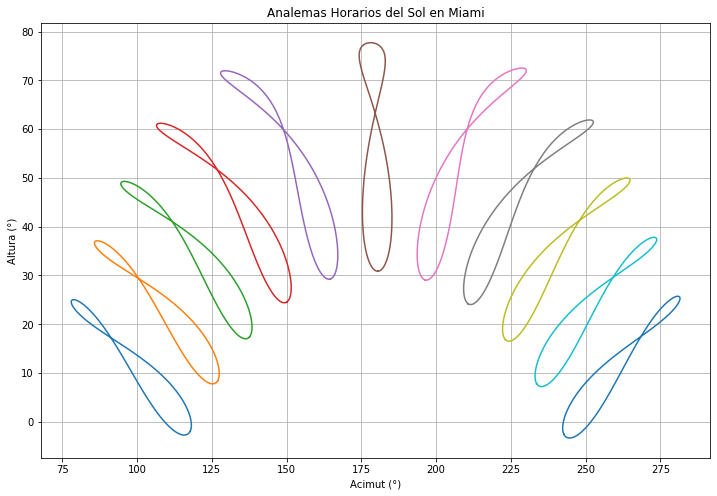

In [6]:
plt.figure(figsize=(12,8))
plt.title("Analemas Horarios del Sol en Miami")
plt.xlabel("Acimut (°)")
plt.ylabel("Altura (°)")
plt.grid()
for h in range(Nhoras):
    plt.plot(Altacim[h][:,0],Altacim[h][:,1],label=h)

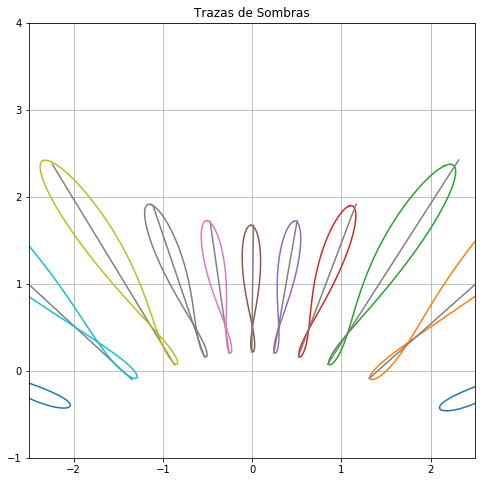

In [7]:
plt.figure(figsize=(8,8))
plt.title("Trazas de Sombras")
plt.grid()
plt.xlim([-2.5,2.5])
plt.ylim([-1,4])
for h in range(Nhoras):
    plt.plot(-PointsXY[h][:,0],PointsXY[h][:,1])
    plt.plot(HoraMinMaxXY[h][:,0],HoraMinMaxXY[h][:,1],color='grey')

C:\Users\agustin.vallejo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


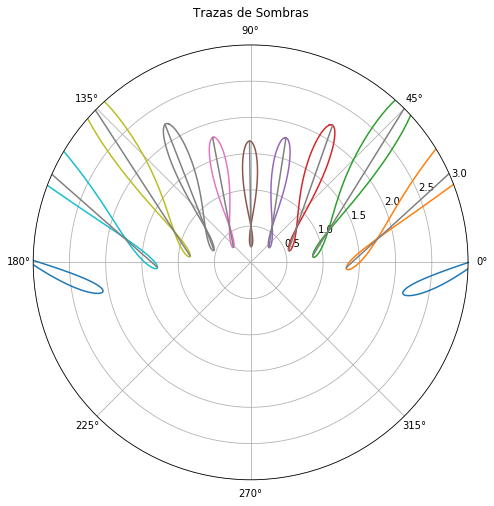

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='polar')
plt.title("Trazas de Sombras")
plt.grid(True)
plt.ylim([0,3])
k = 1
for h in range(Nhoras):
    plt.plot(PointsTR[h][:,0]+np.pi/2,PointsTR[h][:,1])
    plt.plot(HoraMinMaxTR[h][:,0]+np.pi/2,HoraMinMaxTR[h][:,1],color='grey')

In [9]:
PointsTR2 = np.zeros((Ndias,Nhoras,2))
PointsXY2 = np.zeros((Ndias,Nhoras,2))

for d in range(Ndias):
    for h in range(Nhoras):
        PointsTR2[d,h] = PointsTR[h,d]
        PointsXY2[d,h] = PointsTR[h,d]

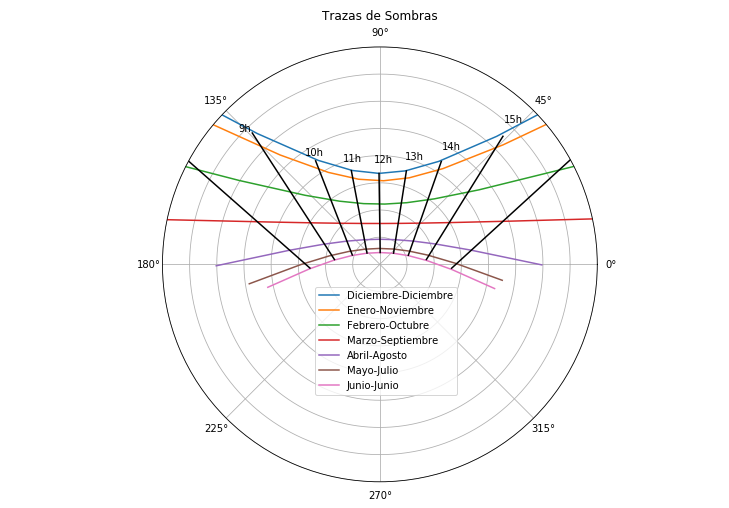

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='polar')
plt.yticks(np.arange(0, 5, 0.5),[])
plt.title("Trazas de Sombras")
plt.grid(True)
plt.ylim([0,4])


Nums = np.linspace(0,Ndias,13) #Nums divide el año en los 12 meses
Meses = ['Enero','Febrero','Marzo','Abril','Mayo',
        'Junio','Julio','Agosto','Septiembre',
        'Octubre','Noviembre','Diciembre']
c = 0
for h in Nums[:7]: #Pero solo se usa la mitad de Nums porque las lineas de Meses no coinciden exactamente y se ve feo
    k = int(h) - 1
    if c < 7:
        txt = Meses[c-1]+"-"+Meses[-c-1]
    else: txt=None
    plt.plot(PointsTR2[k][:,0]+np.pi/2,PointsTR2[k][:,1],label=txt)
    c += 1
plt.legend(loc=[0.35,0.2])    

for h in range(Nhoras):
    plt.plot(HoraMinMaxTR[h][:,0]+np.pi/2,HoraMinMaxTR[h][:,1],'k-')
    
    n = 24-h-7
    txt = str(n)+"h"
    plt.annotate(s=txt,xy=HoraMinMaxTR[h][1]+[1.03*np.pi/2,0.2])
    


[ 0.   7.5 15.  22.5 30.  37.5 45.  52.5 60.  67.5 75.  82.5 90. ]


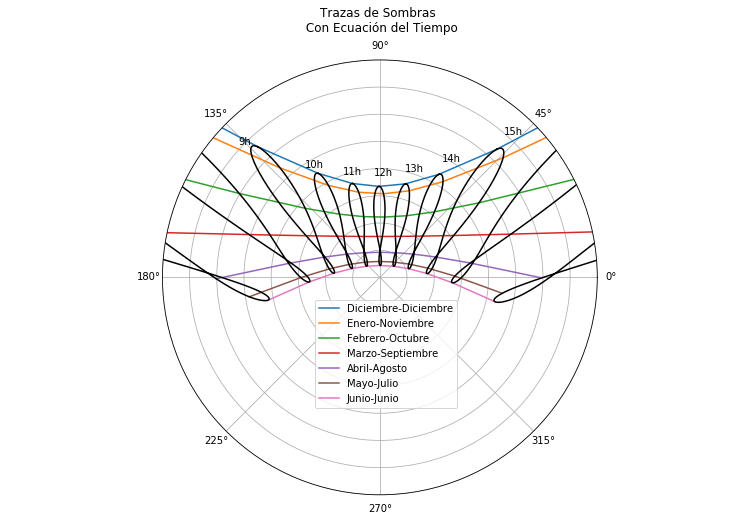

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='polar')
plt.yticks(np.arange(0, 5, 0.5),[])
plt.title("Trazas de Sombras \n Con Ecuación del Tiempo")
plt.grid(True)
plt.ylim([0,4])


Nums = np.linspace(0,Ndias,13)
print(Nums)
Meses = ['Enero','Febrero','Marzo','Abril','Mayo',
        'Junio','Julio','Agosto','Septiembre',
        'Octubre','Noviembre','Diciembre']
c = 0
for h in Nums[:7]:
    k = int(h) - 1
    if c < 7:
        txt = Meses[c-1]+"-"+Meses[-c-1]
    else: txt=None
    plt.plot(PointsTR2[k][:,0]+np.pi/2,PointsTR2[k][:,1],label=txt)
    c += 1
plt.legend(loc=[0.35,0.2])    

for h in range(Nhoras):
    plt.plot(PointsTR[h][:,0]+np.pi/2,PointsTR[h][:,1],'k-')
    
    n = 24-h-7
    txt = str(n)+"h"
    plt.annotate(s=txt,xy=HoraMinMaxTR[h][1]+[1.03*np.pi/2,0.2])

In [12]:
save3d("Altacim",Altacim)
save3d("PointsXY",PointsXY)
save3d("PointsTR",PointsTR)
save3d("PointsXY2",PointsXY2)
save3d("PointsTR2",PointsTR2)
save3d("HoraMinMaxXY",HoraMinMaxXY)
save3d("HoraMinMaxTR",HoraMinMaxTR)